In [43]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
import itertools

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

In [44]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/5seqs_in_10percent_samples/nochloro_absolute_otu_5in10percent.tsv', sep=' ', index_col=None, header=0, float_precision='high')
data_rel = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/5seqs_in_10percent_samples/nochloro_relative_5in10percent.tsv', sep=' ', index_col=None, header=0, float_precision='high')
target = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/5seqs_in_10percent_samples/nochloro_HNA_LNA_5in10percent.tsv', sep= ' ', index_col=0, header=0)
productivity = pd.read_table('data/Chloroplasts_removed/productivity_data_v2.tsv', index_col=0, header=0)

In [45]:
'''Set sample names as index and shuffle data'''
index = target.Lake[target.Lake == 'Muskegon'].index

#Remove outlier samples:
data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
productivity = productivity.loc[index,:]

#Shuffle data: 
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
productivity = productivity.sample(frac=1, random_state=3) 

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[:,'LNA.cells']
lna_rel = lna/target.loc[:,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

In [46]:
hna_scores = pd.read_csv('Scores/hnascores_otus_5seq10_rel_Muskegon.csv', index_col=0)

In [47]:
tot_bacprod = productivity.loc[:,'tot_bacprod'].dropna()
index_prod = tot_bacprod[tot_bacprod.values < 90].index
prod = productivity.loc[index_prod,'tot_bacprod']

In [48]:
r_spearman_abs = np.zeros(hna_scores.shape[0])
p_spearman_abs = np.zeros(hna_scores.shape[0])
r_spearman_rel = np.zeros(hna_scores.shape[0])
p_spearman_rel = np.zeros(hna_scores.shape[0])

i=0
for otu in hna_scores.index:
    r_spearman_abs[i], p_spearman_abs[i] = spearmanr(data_abs.loc[index_prod,otu],prod,axis=0, nan_policy='omit')
    r_spearman_rel[i], p_spearman_rel[i] = spearmanr(data_rel.loc[index_prod,otu],prod,axis=0, nan_policy='omit')
    i+=1
    
hna_scores['r_spearman_prod_abs'] = r_spearman_abs
hna_scores['p_spearman_prod_abs'] = p_spearman_abs
hna_scores['r_spearman_prod_rel'] = r_spearman_rel
hna_scores['p_spearman_prod_rel'] = p_spearman_rel

/home/prubbens/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/prubbens/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/prubbens/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/prubbens/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/prubbens/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [49]:
display(hna_scores.head(5))

,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,r_spearman,p_spearman,r_spearman_prod_abs,p_spearman_prod_abs,r_spearman_prod_rel,p_spearman_prod_rel
Otu000173,0.506667,20268.358440,1.283122,0.002885,1.143738,0.730720,8.157897e-09,0.351880,0.128142,0.294565,0.207413
Otu000060,0.506667,46181.078013,0.873029,0.006852,0.585652,0.659880,6.086561e-07,0.601504,0.005023,0.444528,0.049560
Otu000067,0.416667,18713.670192,1.244368,0.002856,1.086117,0.540232,1.065000e-04,0.596465,0.005504,0.521838,0.018276
Otu000262,0.416667,2853.211884,1.557861,0.000524,1.411830,-0.515411,2.468114e-04,-0.723643,0.000310,-0.725142,0.000297
Otu000059,0.410000,32741.311335,0.537621,0.005853,0.498993,-0.231685,1.213137e-01,0.212030,0.369486,0.028647,0.904572


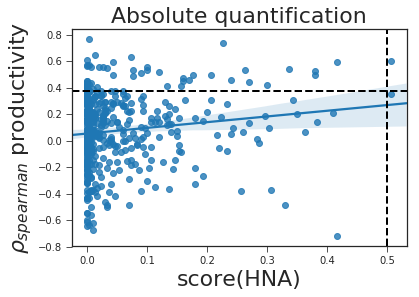

In [50]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=hna_scores.loc[:,'r_spearman_prod_abs'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel(r'$\rho_{spearman}$ productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('Absolute quantification', size=22)
plt.show()

In [51]:
otus_prod = hna_scores[(hna_scores.loc[:,'score'] > 0.5) & (hna_scores.loc[:,'r_spearman_prod_abs'] > 0.377)].index

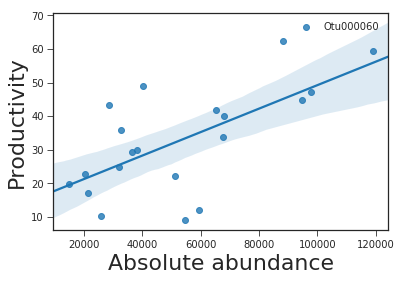

In [52]:
palette = itertools.cycle(sns.color_palette())
for otu in otus_prod: 
    plt.figure()
    sns.regplot(x=data_abs.loc[index_prod,otu],y=prod,label=otu, color=next(palette), fit_reg=True)
    plt.xlabel('Absolute abundance', size=22)
    plt.xticks(size=10)
    plt.ylabel('Productivity', size=22)
    plt.yticks(size=10)
    plt.legend()
    plt.show()
    i+=1

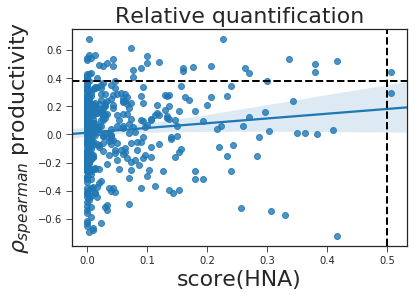

In [53]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=hna_scores.loc[:,'r_spearman_prod_rel'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel(r'$\rho_{spearman}$ productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('Relative quantification', size=22)
plt.show()

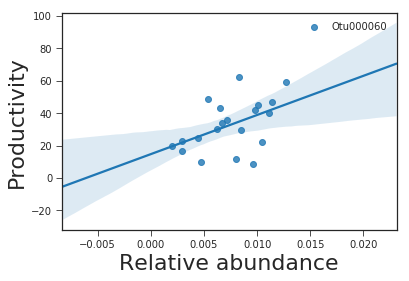

In [54]:
otus_prod = hna_scores[(hna_scores.loc[:,'score'] > 0.5) & (hna_scores.loc[:,'r_spearman_prod_rel'] > 0.377)].index
palette = itertools.cycle(sns.color_palette())
for otu in otus_prod: 
    plt.figure()
    sns.regplot(x=data_rel.loc[index_prod,otu],y=prod,label=otu, color=next(palette), fit_reg=True)
    plt.xlabel('Relative abundance', size=22)
    plt.xticks(size=10)
    plt.ylabel('Productivity', size=22)
    plt.yticks(size=10)
    plt.legend()
    plt.show()
    i+=1